## Diffusion Transformer
_(but Flow Matching instead of Diffusion)_

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
import matplotlib.pyplot as plt

/home/user/prj/dit_example/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step-by-step implementation of the DiT model - sampling
1. model definition and instantiation
2. loading pretrained weight (weight link: https://drive.google.com/file/d/1VWs0PjnBClpNAbltA7SEesgduXAxhB3L/view?usp=drive_link)
3. sampling function
4. generating samples

### 1. Model definition and instantiation

In [2]:
def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


#################################################################################
#                             Flow DiT Model                                    #
#################################################################################

class DiTBlock(nn.Module):
    """
    A Flow DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of Flow DiT - outputs velocity field.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    """
    Flow matching model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels  # Flow matching outputs velocity field same size as input
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of Flow DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of flow timesteps (0 to 1)
        y: (N,) tensor of class labels
        Returns: velocity field v(x_t, t, y) of same shape as x
        """
        x = self.x_embedder(x)
        x = x + self.pos_embed
        t = self.t_embedder(t)
        y = self.y_embedder(y, self.training)  
        c = t + y
        for block in self.blocks:
            x = block(x, c)
        x = self.final_layer(x, c)
        x = self.unpatchify(x)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass with classifier-free guidance.
        """
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        cond_v, uncond_v = torch.split(model_out, len(model_out) // 2, dim=0)
        half_v = uncond_v + cfg_scale * (cond_v - uncond_v)
        v = torch.cat([half_v, half_v], dim=0)
        return v


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

### 2. loading pretrained weights

In [4]:
kwargs = dict(
    input_size=28, in_channels=1, num_classes=10, class_dropout_prob=0.1
)
model = DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
filepath = "dit_mnist_s2.pt" # downloaded from the link
checkpoint = torch.load(filepath, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### 3. sampling function

In [5]:
@torch.no_grad()
def sample_images(model, device, num_samples=16, num_steps=50, class_labels=None, cfg_scale=1.0):
    """Generate samples using Euler integration"""
    model.eval()
    
    # Start from noise
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Class labels
    if class_labels is None:
        y = torch.randint(0, 10, (num_samples,), device=device)
    else:
        if isinstance(class_labels, int):
            y = torch.full((num_samples,), class_labels, device=device)
        else:
            y = torch.tensor(class_labels, device=device)
    
    # Integration step size
    dt = 1.0 / num_steps
    
    # Euler integration
    for step in range(num_steps):
        t = torch.full((num_samples,), step * dt, device=device)
        
        if cfg_scale > 1.0:
            # Use classifier-free guidance
            # Duplicate samples for conditional and unconditional paths
            x_doubled = torch.cat([x, x], dim=0)
            t_doubled = torch.cat([t, t], dim=0)
            y_doubled = torch.cat([y, torch.full_like(y, 10)], dim=0)  # 10 is unconditional class
            
            # Predict velocity
            v_pred = model(x_doubled, t_doubled, y_doubled)
            
            # Split and apply CFG
            v_cond, v_uncond = torch.chunk(v_pred, 2, dim=0)
            v_pred = v_uncond + cfg_scale * (v_cond - v_uncond)
        else:
            # Standard prediction
            v_pred = model(x, t, y)
        
        # Euler step: x_{t+dt} = x_t + dt * v_pred
        x = x + dt * v_pred
    
    # Clamp to [-1, 1] range and convert to [0, 1] for visualization
    x = torch.clamp(x, -1, 1)
    x = (x + 1) / 2
    
    return x, y

In [6]:
samples, labels = sample_images(model, device, num_samples=16, num_steps=50, cfg_scale=2.0)

### 4. generating samples

In [7]:
def visualize_samples(images, labels, save_path=None, title="Generated Samples"):
    """Visualize generated samples"""
    num_samples = images.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    if grid_size == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()
        label = labels[i].cpu().item()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class: {label}')
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Samples saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()

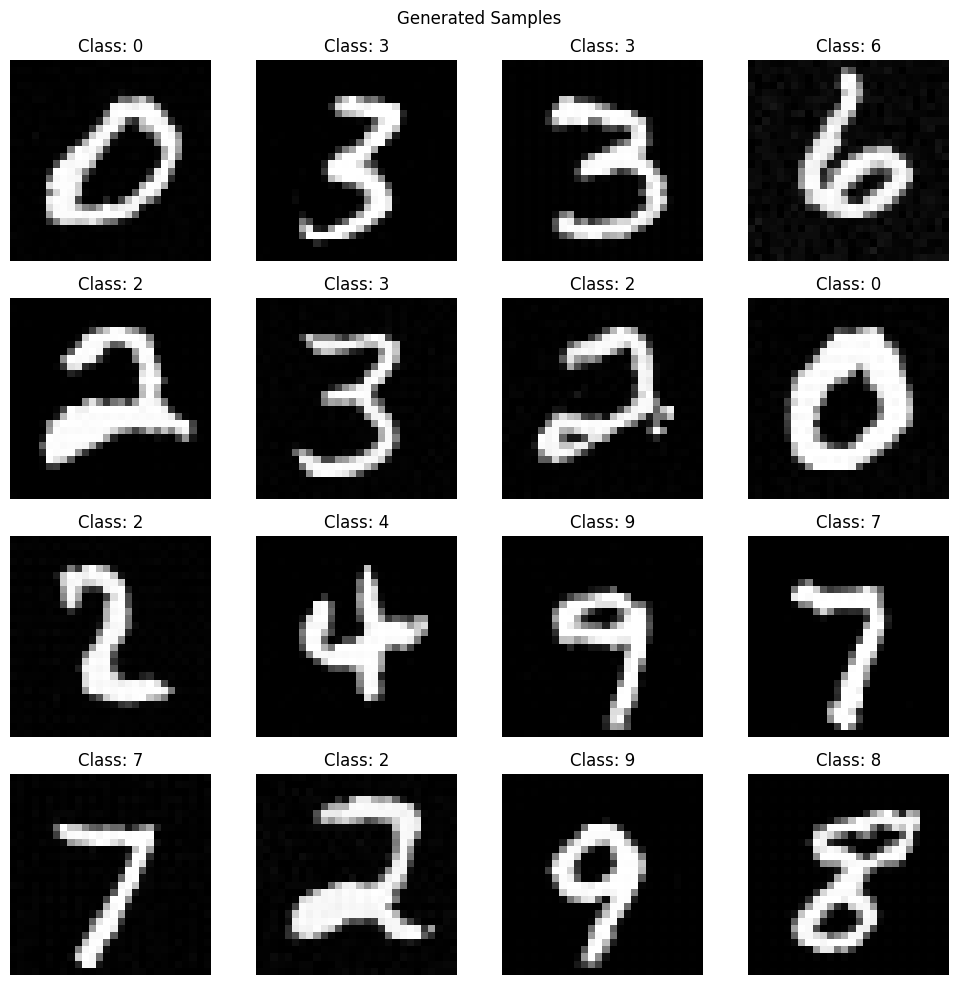

In [8]:
visualize_samples(samples, labels, title="Generated Samples")